In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
%matplotlib inline

In [2]:
amazon_train, amazon_test = ('data/train/AMZN_train.csv', 'data/test/AMZN_test.csv')
apple_train, apple_test = ('data/train/Apple_train.csv', 'data/test/Apple_test.csv')
baba_train, baba_test = ('data/train/BABA_train.csv', 'data/test/BABA_test.csv')
bac_train, bac_test = ('data/train/BAC_train.csv', 'data/test/BAC_test.csv')
coke_train, coke_test = ('data/train/Coke_train.csv', 'data/test/Coke_test.csv')
disney_train, disney_test = ('data/train/Disney_train.csv', 'data/test/Disney_test.csv')
goldman_sachs_train, goldman_sachs_test = ('data/train/GoldmanSachs_train.csv', 'data/test/GoldmanSachs_test.csv')
roku_train, roku_test = ('data/train/ROKU_train.csv', 'data/test/ROKU_test.csv')
tsla_train, tsla_test = ('data/train/TSLA_train.csv', 'data/test/TSLA_test.csv')
wells_fargo_train, wells_fargo_test = ('data/train/WellsFargo_train.csv', 'data/test/WellsFargo_test.csv')

In [3]:
def get_data_regressor(train_data_path: str, test_data_path: str):
    train_reg = pd.read_csv(train_data_path, parse_dates=[0])
    test_reg = pd.read_csv(test_data_path, parse_dates=[0])
    train_reg.index = train_reg['Date']
    test_reg.index = test_reg['Date']
    return train_reg, test_reg

def get_data_time_series(train_data_path: str, test_data_path: str):
    train_time_series = pd.read_csv(train_data_path, parse_dates=[0], index_col=0)
    test_time_series = pd.read_csv(test_data_path, parse_dates=[0], index_col=0)    
    return train_time_series, test_time_series

In [4]:
def preprocess_data(train: pd.DataFrame, test: pd.DataFrame):
    train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    

For Regressor Methods Only!

In [5]:
import re
# source -> https://github.com/fastai/fastai/blob/release-1.0.6/old/fastai/structured.py
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace."""
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

    # Hypothesis is that the first and last days of the week could potentially affect 
    # the closing price of stock respective to other days. So, create a feature that identifies
    # opening day and closing day
    df['mon_fri'] = [1 if (df['Dayofweek'][i] == 0 or df['Dayofweek'][i] == 4) else 0 for i in range(0, len(df))] 

Regressor Methods

In [6]:
def run_linear_regression(x_train, y_train):
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    return lin_reg

def run_svr(x_train, y_train):
    svm = SVR(kernel='poly', degree=4, C=3)
    svm.fit(x_train, y_train)
    return svm

def run_random_forest(x_train, y_train):
    rand_forest = RandomForestRegressor()
    rand_forest.fit(x_train, y_train)
    return rand_forest

In [7]:
def run_regression_for_stock_prediction(train_data_path, test_data_path, method):
    train, test = get_data_regressor(train_data_path, test_data_path)
    preprocess_data(train, test)
    add_datepart(train, 'Date')
    add_datepart(test, 'Date')
    train.drop('Elapsed', axis=1, inplace=True)
    test.drop('Elapsed', axis=1, inplace=True)
    x_train = train.drop('Adj Close', axis=1)
    y_train = train['Adj Close']
    
    x_test = test.drop('Adj Close', axis=1)
    y_test = test['Adj Close']
    del train_data_path, test_data_path
    if method == 'linear':
        lin_reg = run_linear_regression(x_train, y_train)
        lin_reg_predict = lin_reg.predict(x_test)
        lin_reg_mse = mean_squared_error(y_test, lin_reg_predict)
        return lin_reg_mse
    elif method == 'svr':
        svr_reg = run_svr(x_train, y_train)
        svr_reg_predict = svr_reg.predict(x_test)
        svr_reg_mse = mean_squared_error(y_test, svr_reg_predict)
        return svr_reg_mse
    elif method == 'random':
        random_reg = run_random_forest(x_train, y_train)
        random_reg_predict = random_reg.predict(x_test)
        random_reg_mse = mean_squared_error(y_test, random_reg_predict)
        return random_reg_mse
    else:
        raise TypeError('Could not understand type of Regressor!')
        

Time Series

In [8]:
def run_time_series(train_data_path: str, test_data_path: str, order: tuple, method: str):
    train, test = get_data_time_series(train_data_path, test_data_path)
    preprocess_data(train, test)
    if method == 'ARIMA':
        time_series = ARIMA
    elif method == 'ARMA':
        time_series = ARMA
    else:
        raise TypeError('Could not understand type of time series method!')
    historical_data = [x for x in train['Adj Close']]
    predictions_lst = list()
    for t in range(len(test)):
        current_data = test['Adj Close'][t]
        #forecast value
        model = time_series(historical_data, order)
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
        #print('Actual=%f, Predicted=%f, error=%f' %(current_data, prediction, abs(current_data - prediction)))
        predictions_lst.append(prediction)
        historical_data.append(current_data)
    mse = mean_squared_error(test['Adj Close'], predictions_lst)
    return mse

Run Linear Regression!

In [9]:
amazon_linear_mse = run_regression_for_stock_prediction(amazon_train, amazon_test, method='linear')
apple_linear_mse = run_regression_for_stock_prediction(apple_train, apple_test, method='linear')
baba_linear_mse = run_regression_for_stock_prediction(baba_train, baba_test, method='linear')
bac_linear_mse = run_regression_for_stock_prediction(bac_train, bac_test, method='linear')
coke_linear_mse = run_regression_for_stock_prediction(coke_train, coke_test, method='linear')
disney_linear_mse = run_regression_for_stock_prediction(disney_train, disney_test, method='linear')
goldman_sachs_linear_mse = run_regression_for_stock_prediction(goldman_sachs_train, goldman_sachs_test, method='linear')
roku_linear_mse = run_regression_for_stock_prediction(roku_train, roku_test, method='linear')
tsla_linear_mse = run_regression_for_stock_prediction(tsla_train, tsla_test, 'linear')
wells_fargo_linear_mse = run_regression_for_stock_prediction(wells_fargo_train, wells_fargo_test, 'linear')

Run SVR!

In [10]:
amazon_svr_mse = run_regression_for_stock_prediction(amazon_train, amazon_test, method='svr')
apple_svr_mse = run_regression_for_stock_prediction(apple_train, apple_test, method='svr')
baba_svr_mse = run_regression_for_stock_prediction(baba_train, baba_test, method='svr')
bac_svr_mse = run_regression_for_stock_prediction(bac_train, bac_test, method='svr')
coke_svr_mse = run_regression_for_stock_prediction(coke_train, coke_test, method='svr')
disney_svr_mse = run_regression_for_stock_prediction(disney_train, disney_test, method='svr')
goldman_sachs_svr_mse = run_regression_for_stock_prediction(goldman_sachs_train, goldman_sachs_test, method='svr')
roku_svr_mse = run_regression_for_stock_prediction(roku_train, roku_test, method='svr')
tsla_svr_mse = run_regression_for_stock_prediction(tsla_train, tsla_test, 'svr')
wells_fargo_svr_mse = run_regression_for_stock_prediction(wells_fargo_train, wells_fargo_test, 'svr')

Run Random Forest!

In [11]:
amazon_random_mse = run_regression_for_stock_prediction(amazon_train, amazon_test, method='random')
apple_random_mse = run_regression_for_stock_prediction(apple_train, apple_test, method='random')
baba_random_mse = run_regression_for_stock_prediction(baba_train, baba_test, method='random')
bac_random_mse = run_regression_for_stock_prediction(bac_train, bac_test, method='random')
coke_random_mse = run_regression_for_stock_prediction(coke_train, coke_test, method='random')
disney_random_mse = run_regression_for_stock_prediction(disney_train, disney_test, method='random')
goldman_sachs_random_mse = run_regression_for_stock_prediction(goldman_sachs_train, goldman_sachs_test, method='random')
roku_random_mse = run_regression_for_stock_prediction(roku_train, roku_test, method='random')
tsla_random_mse = run_regression_for_stock_prediction(tsla_train, tsla_test, 'random')
wells_fargo_random_mse = run_regression_for_stock_prediction(wells_fargo_train, wells_fargo_test, 'random')

Run ARIMA!

In [12]:
order = (2, 1, 1)
amazon_arima_mse = run_time_series(amazon_train, amazon_test, order, method='ARIMA')
apple_arima_mse = run_time_series(apple_train, apple_test, order, method='ARIMA')
baba_arima_mse = run_time_series(baba_train, baba_test, order, method='ARIMA')
bac_arima_mse = run_time_series(bac_train, bac_test, order, method='ARIMA')
coke_arima_mse = run_time_series(coke_train, coke_test, order, method='ARIMA')
disney_arima_mse = run_time_series(disney_train, disney_test, order, method='ARIMA')
goldman_sachs_arima_mse = run_time_series(goldman_sachs_train, goldman_sachs_test, order, method='ARIMA')
roku_arima_mse = run_time_series(roku_train, roku_test, order, method='ARIMA')
tsla_arima_mse = run_time_series(tsla_train, tsla_test, order, 'ARIMA')
wells_fargo_arima_mse = run_time_series(wells_fargo_train, wells_fargo_test, order, 'ARIMA')

/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting 

In [13]:
order=(3,1)
amazon_arma_mse = run_time_series(amazon_train, amazon_test, order, method='ARMA')
apple_arma_mse = run_time_series(apple_train, apple_test, order, method='ARMA')
baba_arma_mse = run_time_series(baba_train, baba_test, order, method='ARMA')
bac_arma_mse = run_time_series(bac_train, bac_test, order, method='ARMA')
coke_arma_mse = run_time_series(coke_train, coke_test, order, method='ARMA')
disney_arma_mse = run_time_series(disney_train, disney_test, order, method='ARMA')
goldman_sachs_arma_mse = run_time_series(goldman_sachs_train, goldman_sachs_test, order, method='ARMA')
roku_arma_mse = run_time_series(roku_train, roku_test, order, method='ARMA')
tsla_arma_mse = run_time_series(tsla_train, tsla_test, order, 'ARMA')
wells_fargo_arma_mse = run_time_series(wells_fargo_train, wells_fargo_test, order, 'ARMA')

/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/prasangbiyani/Desktop/code/ml/my_env/lib/python3.6/site-packages/statsmodels/base/

In [14]:
# plt.figure(figsize=(50, 50))
# plt.subplot(5,2,1)
# plt.plot(amazon_test_values.values, color='green', label='Test')
# plt.plot(amazon_predict, color='blue', label='Predicted')
# plt.legend(fontsize=30)
# plt.title('AMAZON Mean Squared Error (MSE) %f' %amazon_mse, fontdict={'fontsize': 50})
amazon_errors = [amazon_linear_mse, amazon_svr_mse, amazon_random_mse, amazon_arima_mse, amazon_arma_mse]
apple_errors = [apple_linear_mse, apple_svr_mse, apple_random_mse, apple_arima_mse, apple_arma_mse]
baba_errors = [baba_linear_mse, baba_svr_mse, baba_random_mse, baba_arima_mse, baba_arma_mse]
bac_errors = [bac_linear_mse, bac_svr_mse, bac_random_mse, bac_arima_mse, bac_arma_mse]
coke_errors = [coke_linear_mse, coke_svr_mse, coke_random_mse, coke_arima_mse, coke_arma_mse]
disney_errors = [disney_linear_mse, disney_svr_mse, disney_random_mse, disney_arima_mse, disney_arma_mse]
goldman_sachs_errors = [goldman_sachs_linear_mse, goldman_sachs_svr_mse, goldman_sachs_random_mse, goldman_sachs_arima_mse, goldman_sachs_arma_mse]
roku_errors = [roku_linear_mse, roku_svr_mse, roku_random_mse, roku_arima_mse, roku_arma_mse]
tsla_errors = [tsla_linear_mse, tsla_svr_mse, tsla_random_mse, tsla_arima_mse, tsla_arma_mse]
wells_fargo_errors = [wells_fargo_linear_mse, wells_fargo_svr_mse, wells_fargo_random_mse, wells_fargo_arima_mse, wells_fargo_arma_mse]

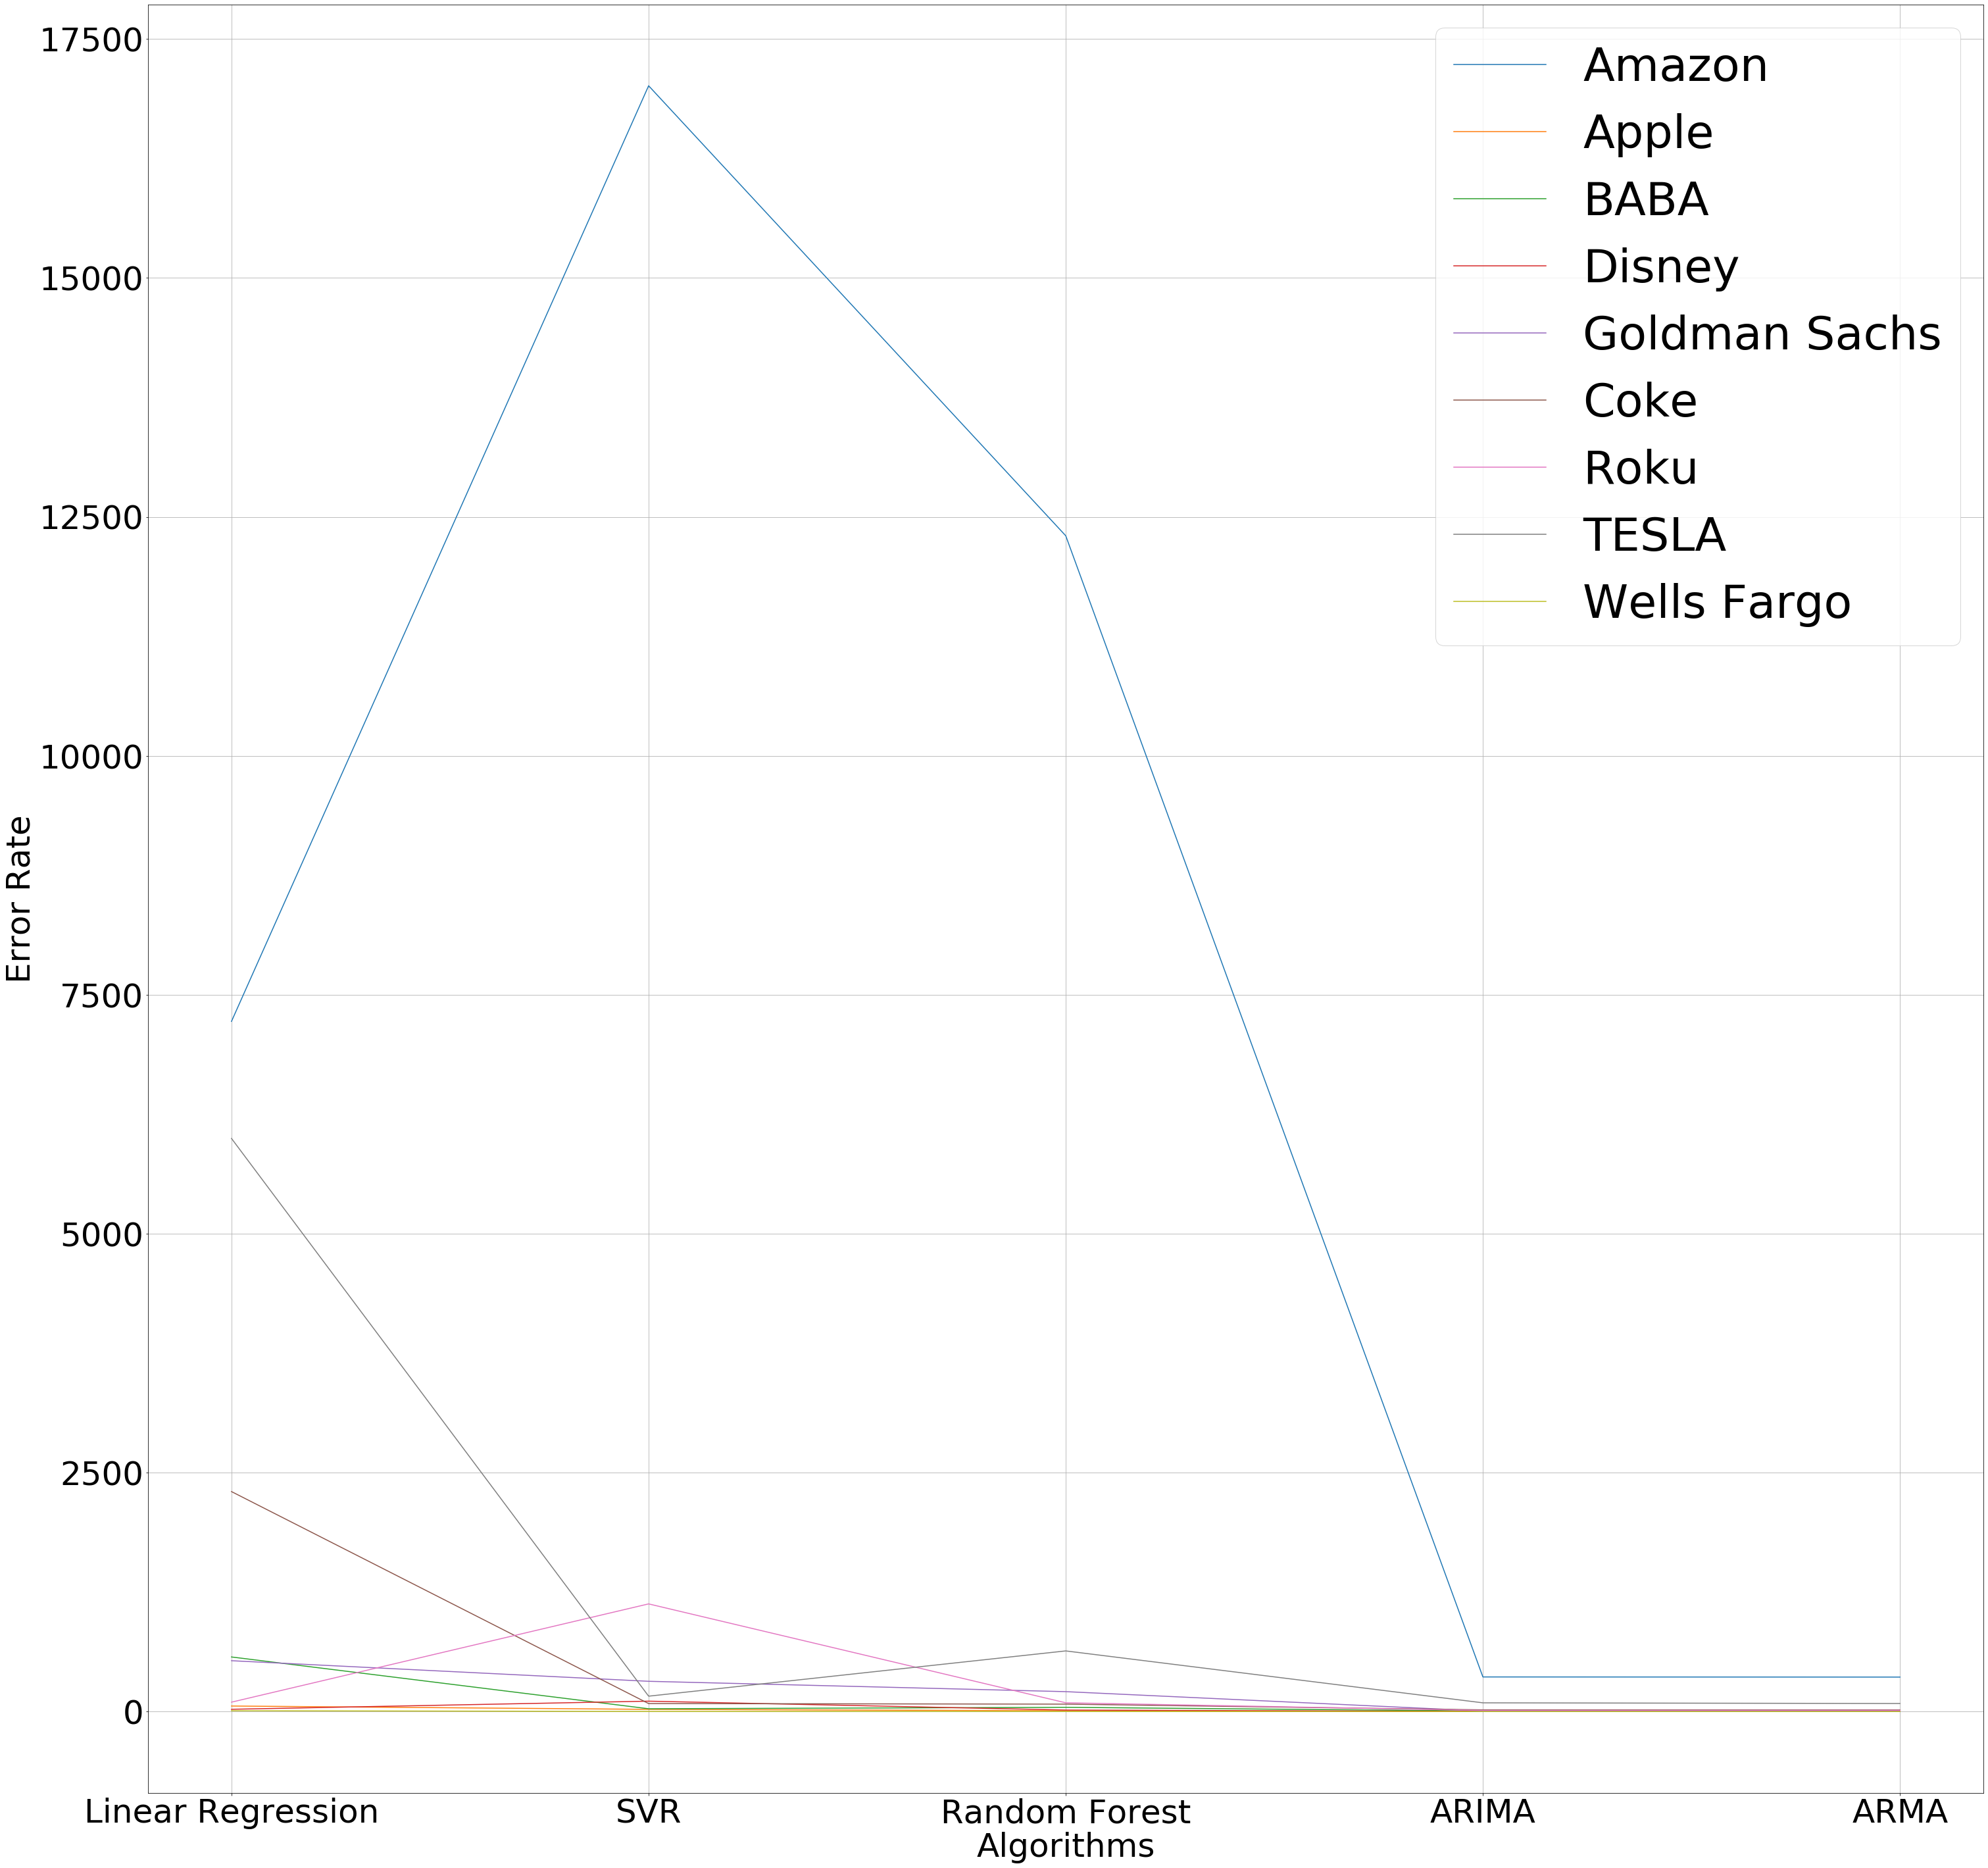

In [16]:
plt.figure(figsize=(50, 50))
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
x = ['Linear Regression', 'SVR', 'Random Forest', 'ARIMA', 'ARMA']
plt.plot(x, amazon_errors, label='Amazon')
plt.plot(x, apple_errors, label='Apple')
plt.plot(x, baba_errors, label='BABA')
plt.plot(x, disney_errors, label='Disney')
plt.plot(x, goldman_sachs_errors, label='Goldman Sachs')
plt.plot(x, coke_errors, label='Coke')
plt.plot(x, roku_errors, label='Roku')
plt.plot(x, tsla_errors, label='TESLA')
plt.plot(x, wells_fargo_errors, label='Wells Fargo')
plt.ylabel('Error Rate', fontsize=50)
plt.xlabel('Algorithms', fontsize=50)
plt.grid()
plt.legend(fontsize=70)
plt.show()